In [1]:
from tqdm import tqdm
import datetime
tqdm.pandas()
import os 
import sys
import pandas as pd
import numpy as np
#connect local PATH
from matplotlib import pyplot as plt
p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))
from CryptoSent.tools.crypto_coin_actual import get_btc_actual_hourly
from CryptoSent.tools import evaluation as eval
from CryptoSent.tools.utils import load_submissions

from sklearn.preprocessing import MinMaxScaler

def errors(x,Y):
    return [Y[i]-x[i] for i in range(len(x))]

def abolute_errors(x,Y):
    return [abs(Y[i]-x[i]) for i in range(len(x))]

    
def mean_error(x,Y):
    return np.mean([Y[i]-x[i] for i in range(len(x))])

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as r2  
from sklearn.metrics import mean_squared_error as mse   #squared=False:rmse
#from sklearn.metrics import mean_squared_log_error as msle      #squared=False:rmsle

evaluation_metrics=[mean_error,mae,mape,mse]
evaluation_metrics_names=['me','mae','mape','mse','rmse',]
def evaluate_pred(x,Y,model_name='m1'):
    scores=[]
    for metric in evaluation_metrics:
        scores.append(metric(x,Y))
    scores.append(mse(x,Y,squared=False))
    output=pd.DataFrame(
        np.array(scores),
        index=evaluation_metrics_names,
        columns=[model_name])
    return output



# import datasets
#subs=load_submissions()
btc=get_btc_actual_hourly().sort_index()
btc['perc']=btc.close.pct_change()
btc['difference']=btc.close.diff()
btc=btc[['close','perc','difference']]
btc=btc.dropna()


100%|██████████| 30907/30907 [00:00<00:00, 167527.38it/s]


                 m1
me         7.708985
mae      404.840478
mape      15.461086
mse   301083.819719
rmse     548.711053


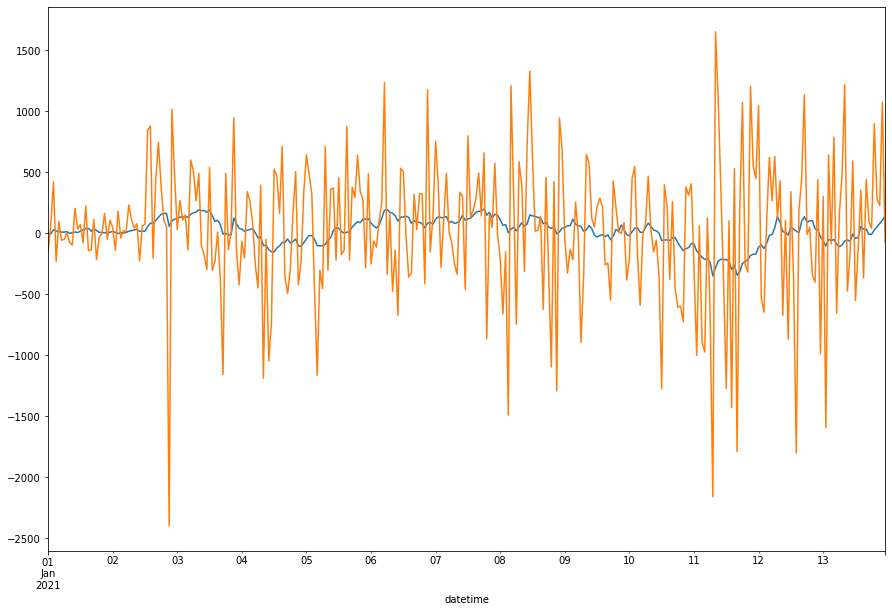

In [2]:
dstart='2021-01-1'
dend='2021-01-13'
rolling_window=24
resample_period='h'
feature='difference'# close, difference, perc

x=btc[feature].resample(resample_period).mean().rolling(rolling_window,min_periods=1).mean()[dstart:dend]
Y=btc[feature].resample(resample_period).mean()[dstart:dend]
print(evaluate_pred(x,Y))
x.plot(figsize=(15,10))
Y.plot(figsize=(15,10))
plt.show()


# SVM

In [307]:
feature='close'# close, difference, perc
resample_period='h'
base=btc[feature].resample(resample_period).mean()


In [308]:
X_train=base[:'2020'].dropna().to_numpy().reshape(-1, 1)


In [419]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train1 = scaler.transform(X_train)
#X_test1 = scaler.transform(Y.reshape(-1,1))  # apply same transformation to test data

winlen=2
x=[]
y=[]
for i in range(len(X_train1)-winlen):
    x.append(X_train1[i:winlen+i])
    y.append(X_train1[winlen+i])
x=np.array(x).reshape(len(x),winlen)
y=np.array(y).reshape(len(y),1)

In [422]:
x.shape


(23075, 2)

In [474]:
# Or better yet: use a pipeline!
from sklearn.pipeline import make_pipeline
from sklearn import svm
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)

m1 = svm.SVR()

neigh.fit(x,y)

KNeighborsRegressor(n_neighbors=2)

In [473]:
base[dstart:dend].head(2).values

array([33532.74, 33769.38])

In [477]:
tp=base[dstart:dend].head(2).values.reshape(1,-1)
tp

array([[33532.74, 33769.38]])

In [484]:
(neigh.predict(tp))

array([[5.45325405]])

In [466]:
base[dstart:dend]

datetime
2021-02-02 00:00:00    33532.74
2021-02-02 01:00:00    33769.38
2021-02-02 02:00:00    33757.09
2021-02-02 03:00:00    33677.60
2021-02-02 04:00:00    33578.04
                         ...   
2021-06-02 19:00:00    38026.25
2021-06-02 20:00:00    38017.80
2021-06-02 21:00:00    37895.52
2021-06-02 22:00:00    37749.27
2021-06-02 23:00:00    37798.90
Freq: H, Name: close, Length: 2904, dtype: float64

<AxesSubplot:>

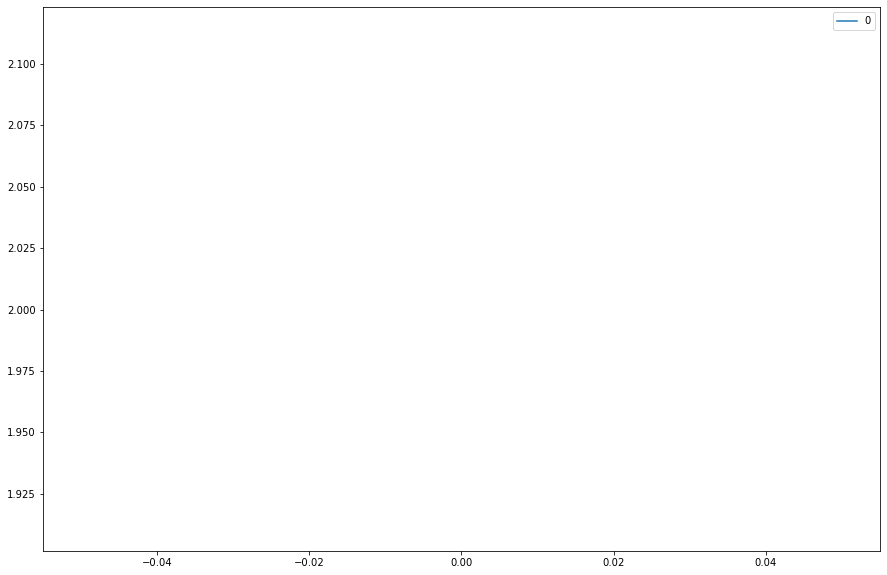

In [440]:
dstart='2021-02-02'
dend='2021-06-02'
#x1=pd.DataFrame(m1.predict(base['2021-01-01':'2021-01-01'].dropna().to_numpy().reshape(-1, 1)),
#index=base[dstart:dend].dropna().index)

x1=pd.DataFrame(m1.predict(tp))
#y1=base[dstart:dend].head(2).dropna()
x1.plot(figsize=(15,10))
#y1.plot()

In [374]:
x.ravel()

array([0.06450415, 0.06171423, 0.06171423, ..., 5.49551163, 5.49551163,
       5.44078569])

In [318]:
evaluate_pred(x1[0],y1)

,m1
me,-12.379867
mae,12.379867
mape,0.000333
mse,153.300958
rmse,12.381476
